# Lesson 3: Preprocessing Videos for Multimodal RAG 

## Setup

In [1]:
from pathlib import Path
import os
from os import path as osp
import json
import cv2
import webvtt
import whisper
from moviepy.editor import VideoFileClip
from PIL import Image
import base64

### Download Video Corpuses

In [2]:
from utils import download_video, get_transcript_vtt
# first video's url
vid1_url = "https://www.youtube.com/watch?v=7Hcg-rLYwdM"

# download Youtube video to ./shared_data/videos/video1
vid1_dir = "./shared_data/videos/video1"
vid1_filepath = download_video(vid1_url, vid1_dir)

# download Youtube video's subtitle to ./shared_data/videos/video1
vid1_transcript_filepath = get_transcript_vtt(vid1_url, vid1_dir)

Getting video information for https://www.youtube.com/watch?v=7Hcg-rLYwdM


In [3]:
# show the paths to video1 and its transcription
print(vid1_filepath)
print(vid1_transcript_filepath)

./shared_data/videos/video1/Welcome back to Planet Earth.mp4
./shared_data/videos/video1/captions.vtt


In [4]:
!head -n15 {vid1_transcript_filepath}

WEBVTT

00:00:03.620 --> 00:00:06.879
As I look back on the the mission that we've had here

00:00:06.879 --> 00:00:10.559
on the International Space Station,
I'm proud to have been a part of much of

00:00:10.559 --> 00:00:13.679
the science activities that happened over the last

00:00:13.680 --> 00:00:14.420
two months.



In [5]:
from urllib.request import urlretrieve
# second video's url
vid2_url=(
    "https://multimedia-commons.s3-us-west-2.amazonaws.com/" 
    "data/videos/mp4/010/a07/010a074acb1975c4d6d6e43c1faeb8.mp4"
)
vid2_dir = "./shared_data/videos/video2"
vid2_name = "toddler_in_playground.mp4"

# create folder to which video2 will be downloaded 
Path(vid2_dir).mkdir(parents=True, exist_ok=True)
vid2_filepath = urlretrieve(
                        vid2_url, 
                        osp.join(vid2_dir, vid2_name)
                    )[0]

### Helper functions

In [6]:
from utils import str2time
from utils import maintain_aspect_ratio_resize

## 1. Video Corpus and Its Transcript Are Available

<p style="background-color:#fff1d7; padding:15px; "> <b>Note:</b> 
    For each video segment, we will extract:
<br>
1. A frame right at the middle of the time frame of the video segment;
<br>
2. Its metadata including:
<br>
-<code>extracted_frame_path</code>: Path to the saved extracted-frame;
<br>
-<code>transcript</code>: Transcript of the extracted frame;
<br>
-<code>video_segment_id</code>: 
    The order of video segment from which the frame
<br>
was extracted;
<br>
-<code>video_path</code>: 
    Path to the video from which the frame was extracted; 
<br>
This helps to retrieve the correct video when there are many ones
<br>
 in your video corpus;
<br>
-<code>mid_time_ms</code>: Time stamp (in ms) of the extracted frame

</p>

In [7]:
# function `extract_and_save_frames_and_metadata``:
#   receives as input a video and its transcript
#   does extracting and saving frames and their metadatas
#   returns the extracted metadatas
def extract_and_save_frames_and_metadata(
        path_to_video, 
        path_to_transcript, 
        path_to_save_extracted_frames,
        path_to_save_metadatas):
    
    # metadatas will store the metadata of all extracted frames
    metadatas = []

    # load video using cv2
    video = cv2.VideoCapture(path_to_video)
    # load transcript using webvtt
    trans = webvtt.read(path_to_transcript)
    
    # iterate transcript file
    # for each video segment specified in the transcript file
    for idx, transcript in enumerate(trans):
        # get the start time and end time in seconds
        start_time_ms = str2time(transcript.start)
        end_time_ms = str2time(transcript.end)
        # get the time in ms exactly 
        # in the middle of start time and end time
        mid_time_ms = (end_time_ms + start_time_ms) / 2
        # get the transcript, remove the next-line symbol
        text = transcript.text.replace("\n", ' ')
        # get frame at the middle time
        video.set(cv2.CAP_PROP_POS_MSEC, mid_time_ms)
        success, frame = video.read()
        if success:
            # if the frame is extracted successfully, resize it
            image = maintain_aspect_ratio_resize(frame, height=350)
            # save frame as JPEG file
            img_fname = f'frame_{idx}.jpg'
            img_fpath = osp.join(
                path_to_save_extracted_frames, img_fname
            )
            cv2.imwrite(img_fpath, image)

            # prepare the metadata
            metadata = {
                'extracted_frame_path': img_fpath,
                'transcript': text,
                'video_segment_id': idx,
                'video_path': path_to_video,
                'mid_time_ms': mid_time_ms,
            }
            metadatas.append(metadata)

        else:
            print(f"ERROR! Cannot extract frame: idx = {idx}")

    # save metadata of all extracted frames
    fn = osp.join(path_to_save_metadatas, 'metadatas.json')
    with open(fn, 'w') as outfile:
        json.dump(metadatas, outfile)
    return metadatas

In [8]:
# output paths to save extracted frames and their metadata 
extracted_frames_path = osp.join(vid1_dir, 'extracted_frame')
metadatas_path = vid1_dir

# create these output folders if not existing
Path(extracted_frames_path).mkdir(parents=True, exist_ok=True)
Path(metadatas_path).mkdir(parents=True, exist_ok=True)

# call the function to extract frames and metadatas
metadatas = extract_and_save_frames_and_metadata(
                vid1_filepath, 
                vid1_transcript_filepath,
                extracted_frames_path,
                metadatas_path,
            )
                     

In [9]:
metadatas[:4]

[{'extracted_frame_path': './shared_data/videos/video1/extracted_frame/frame_0.jpg',
  'transcript': "As I look back on the the mission that we've had here",
  'video_segment_id': 0,
  'video_path': './shared_data/videos/video1/Welcome back to Planet Earth.mp4',
  'mid_time_ms': 5249.5},
 {'extracted_frame_path': './shared_data/videos/video1/extracted_frame/frame_1.jpg',
  'transcript': "on the International Space Station, I'm proud to have been a part of much of",
  'video_segment_id': 1,
  'video_path': './shared_data/videos/video1/Welcome back to Planet Earth.mp4',
  'mid_time_ms': 8719.0},
 {'extracted_frame_path': './shared_data/videos/video1/extracted_frame/frame_2.jpg',
  'transcript': 'the science activities that happened over the last',
  'video_segment_id': 2,
  'video_path': './shared_data/videos/video1/Welcome back to Planet Earth.mp4',
  'mid_time_ms': 12119.0},
 {'extracted_frame_path': './shared_data/videos/video1/extracted_frame/frame_3.jpg',
  'transcript': 'two months

## 2. Video Corpus without Available Transcript

In [10]:
path_to_video_no_transcript = vid1_filepath

# declare where to save .mp3 audio
path_to_extracted_audio_file = os.path.join(vid1_dir, 'audio.mp3')

# extract mp3 audio file from mp4 video video file
clip = VideoFileClip(path_to_video_no_transcript)
clip.audio.write_audiofile(path_to_extracted_audio_file)

MoviePy - Writing audio in ./shared_data/videos/video1/audio.mp3


MoviePy - Done.


<p style="background-color:#fff1d7; padding:15px; "> <b>Notes:</b>
<br>
- This process usually takes a long time, around 1-2 minutes.
<br>
- For better performance, depend on how much memory your system has, 
<br>
you might want to try larger whisper models (e.g., large-v2) and
<br>
try setting <code>best_of=5</code>
</p>

In [11]:
model = whisper.load_model("small")
options = dict(task="translate", best_of=1, language='en')
results = model.transcribe(path_to_extracted_audio_file, **options)

100%|████████████████████████████████████████| 461M/461M [00:04<00:00, 107MiB/s]


In [12]:
results

{'text': " As I look back on the mission that we've had here on the International Space Station, I'm proud to have been a part of much of the science activities that happened over the last two months. The view is always amazing though. I didn't think I would do another spacewalk and to now have the chance to have done four more was just icing on the cake for a wonderful mission. The tenth one, do you like the first one? No. A little more comfortable on your tenth one. It's hard to put into words just what it was like to be a part of this expedition, the Expedition 63. It'll be kind of a memory that will last a lifetime for me. It's been a true honor. Dragon Space X, Undock sequence commanded. The roster's looking good. The hardest part was getting us launched, but the most important part is bringing us home. I've been telling Daddy we love you. Hurry home so we can go get my dog. Flashdown. Welcome back to Planet Earth and thanks for flying Space X. It's truly our honor and privilege. 

In [13]:
from utils import getSubs
vtt = getSubs(results["segments"], "vtt")

# path to save generated transcript of video1
path_to_generated_trans = osp.join(vid1_dir, 'generated_video1.vtt')
# write transcription to file
with open(path_to_generated_trans, 'w') as f:
    f.write(vtt)

In [14]:
!head {path_to_generated_trans}

WEBVTT

00:00.000 --> 00:08.780
 As I look back on the mission that we've had here on the International Space Station,

00:08.780 --> 00:13.300
 I'm proud to have been a part of much of the science activities that happened over the

00:13.300 --> 00:14.300
 last two months.


## 3. Video Corpus without Language

In [15]:
lvlm_prompt = "Can you describe the image?"

### LVLM Inference Example

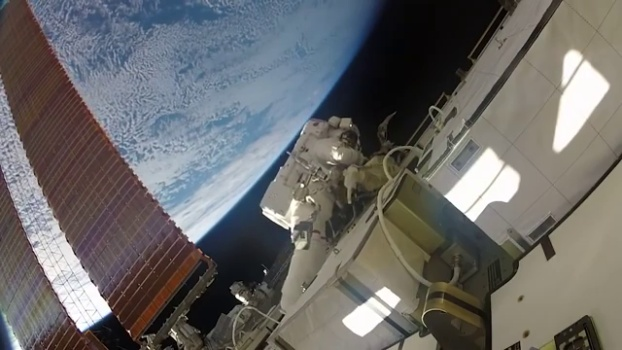

In [16]:
path_to_frame = osp.join(vid1_dir, "extracted_frame", "frame_5.jpg")
frame = Image.open(path_to_frame)
frame

In [17]:
from utils import lvlm_inference, encode_image
# need to encode this frame with base64 encoding 
#  as input image to function lvlm_inference
# encode image to base64
image = encode_image(path_to_frame)
caption = lvlm_inference(lvlm_prompt, image)
print(caption)



The image features a space shuttle with a person inside, floating in the air. The shuttle is positioned in the middle of the scene, and the person appears to be working on the spacecraft. 

There are several other people in the image, some of them standing near the shuttle, while others are scattered throughout the scene. The presence of multiple people suggests that this could be a busy space station or a location where people are working on various tasks related to space exploration.


### Extract Frames and Metadata for Videos Using LVLM Inference

In [18]:
# function extract_and_save_frames_and_metadata_with_fps
#   receives as input a video 
#   does extracting and saving frames and their metadatas
#   returns the extracted metadatas
def extract_and_save_frames_and_metadata_with_fps(
        path_to_video,  
        path_to_save_extracted_frames,
        path_to_save_metadatas,
        num_of_extracted_frames_per_second=1):
    
    # metadatas will store the metadata of all extracted frames
    metadatas = []

    # load video using cv2
    video = cv2.VideoCapture(path_to_video)
    
    # Get the frames per second
    fps = video.get(cv2.CAP_PROP_FPS)
    # Get hop = the number of frames pass before a frame is extracted
    hop = round(fps / num_of_extracted_frames_per_second) 
    curr_frame = 0
    idx = -1
    while(True):
        # iterate all frames
        ret, frame = video.read()
        if not ret: 
            break
        if curr_frame % hop == 0:
            idx = idx + 1
        
            # if the frame is extracted successfully, resize it
            image = maintain_aspect_ratio_resize(frame, height=350)
            # save frame as JPEG file
            img_fname = f'frame_{idx}.jpg'
            img_fpath = osp.join(
                            path_to_save_extracted_frames, 
                            img_fname
                        )
            cv2.imwrite(img_fpath, image)

            # generate caption using lvlm_inference
            b64_image = encode_image(img_fpath)
            caption = lvlm_inference(lvlm_prompt, b64_image)
                
            # prepare the metadata
            metadata = {
                'extracted_frame_path': img_fpath,
                'transcript': caption,
                'video_segment_id': idx,
                'video_path': path_to_video,
            }
            metadatas.append(metadata)
        curr_frame += 1
        
    # save metadata of all extracted frames
    metadatas_path = osp.join(path_to_save_metadatas,'metadatas.json')
    with open(metadatas_path, 'w') as outfile:
        json.dump(metadatas, outfile)
    return metadatas

<p style="background-color:#fff1d7; padding:15px; "> <b>Note:</b>
<br>
* The following process usually takes around <b>1</b> minutes.
</p>

In [19]:
# paths to save extracted frames and metadata (their transcripts)
extracted_frames_path = osp.join(vid2_dir, 'extracted_frame')
metadatas_path = vid2_dir

# create these output folders if not existing
Path(extracted_frames_path).mkdir(parents=True, exist_ok=True)
Path(metadatas_path).mkdir(parents=True, exist_ok=True)

# call the function to extract frames and metadatas
metadatas = extract_and_save_frames_and_metadata_with_fps(
                vid2_filepath, 
                extracted_frames_path,
                metadatas_path,
                num_of_extracted_frames_per_second=0.1
            )

In [ ]:
data = metadatas[1]
caption = data['transcript']
print(f'Generated caption is: "{caption}"')
frame = Image.open(data['extracted_frame_path'])
display(frame)

Generated caption is: "The image features a young boy walking on a playground, holding a water bottle in his hand. He is wearing a blue shirt and appears to be enjoying his time at the park. The playground has a bench nearby, providing a place for the boy to sit and relax. The scene captures the essence of a typical day at the park for a young child."


## Try experimenting on your own!

### Notes on running whisper outside of this classroom
To install `whisper`:
```bash
    !pip install git+https://github.com/openai/whisper.git
```

If calling `whisper` model throws an error about `ffmpeg`, you might want to use a FFmpeg static build in https://johnvansickle.com/ffmpeg/ (recommended in https://ffmpeg.org/download.html). 

See the provided bash script `./prepare_ffmpeg.sh` as example (Go to `File` and click `Open`).
